### initialization setting

In [70]:
import pandas as pd
import numpy as np
import time

processing_df= pd.read_csv('Processing_time.csv')
sequence_df = pd.read_csv('Machine_sequence.csv')

processing_df = processing_df.drop(['Job'],axis=1)
sequence_df = sequence_df.drop(['Job'],axis=1)

num_machine = processing_df.shape[0] # number of machines
num_job = processing_df.shape[1] # number of jobs
num_gene = num_machine * num_job # number of genes in a chromosome

pt=[list(map(int, processing_df.iloc[i])) for i in range(num_job)]
ms=[list(map(int,sequence_df.iloc[i])) for i in range(num_job)]

### generate initial population

In [71]:
def inital_population(population_size,population_list):
    for i in range(population_size):
        ini_pop = list(np.random.permutation(num_gene) % num_job) # generate a random permutation of 0 to num_job*num_mc-1
        population_list.append(ini_pop)                           # convert to job number format, every job appears m times
    return population_list

### two point crossover

In [72]:
def crossover(population_list,crossover_rate): 
    parent_list = population_list.copy() # preserve the original parent chromosomes
    offspring_list= population_list.copy()
    parent_sequence =list(np.random.permutation(population_size)) # 產生一個組合去選擇用哪幾組父代染色體進行交配
    for i in range(0,population_size,2):
        crossover_prob=np.random.rand()
        if crossover_prob <= crossover_rate:
            parent_1 = population_list[ parent_sequence[i] ][:]
            parent_2 = population_list[ parent_sequence[i+1] ][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            crossover_point = list( np.random.choice(num_gene, 2, replace=False) ) # 產生2個不同的交配點，並由小到大排序
            crossover_point.sort()
            
            child_1[crossover_point[0]:crossover_point[1]] = parent_2[crossover_point[0]:crossover_point[1]] # parent_2中間的基因移到parent_1中間，產生child1
            child_2[crossover_point[0]:crossover_point[1]] = parent_1[crossover_point[0]:crossover_point[1]] # parent_1中間的基因移到parent_2中間，產生child2

            offspring_list[parent_sequence[i]] = child_1[:]
            offspring_list[parent_sequence[i+1]] = child_2[:]
    return parent_list,offspring_list

### repairment
每個工件在染色體出現的次數為10次，但由於上面進行交配的動作，會導致有些染色體內的工件出現次數會小於10或大於10，而形成一個不可行的排程解，所以這裡必須針對不可行的染色體進行修復動作，使它成為一個可行排程

In [73]:
def repairmet(offspring_list):
    stop = True

    while stop: # 不斷進行修復，直到每個job的出現次數等於machine數
        
        for i in range(population_size):
            unique_elements, counts = np.unique( offspring_list[i] , return_counts=True) #計算每個job的出現次數
            if sum(counts!= num_machine ) != 0: # 有多餘job和缺少的job 
                less_job = np.argmin(counts) # 出現次數缺少的job
                large_job = np.argmax(counts) # 出現次數多出的job
                offspring_array = np.array( offspring_list[i] )
                offspring_job_large_index = np.where( offspring_array == large_job)[0][0] #  出現次數多出的job的第一個出現位置
                offspring_list[i][offspring_job_large_index] = less_job # 出現次數的多的job，使用較少出現的job替代
        counts_sum = 0
        for j in range(population_size): # 檢查每隔chromosome是否出現異常的情況
            unique_elements, counts = np.unique( offspring_list[j] , return_counts=True)
            if sum(counts!= num_machine ) != 0 :
                counts_sum += 1
        if counts_sum == 0:
            stop = False
    return offspring_list

### mutation
依據 mutation selection rate 決定染色體中有多少百分比的基因要進行突變，假設每條染色體有六個基因， mutation selection rate 為0.5，則有3個基因要進行突變。


In [74]:
def mutation(offspring_list,mutation_rate,num_mutation_jobs):
    for i in range(population_size):
        mutation_prob=np.random.rand()
        if  mutation_prob <= mutation_rate:
            mutation_position = list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # 選擇突變的位置
            muta_list = []
            for j in mutation_position:
                muta_list.append(offspring_list[i][j]) # 要突變的基因list
            muta_list.append(muta_list[0]) # 尾部加上第一個基因
            muta_list.pop(0) # 將第一個基因刪除
            count = 0
            for k in mutation_position:
                offspring_list[i][k] = muta_list[count] # 將用突變後的基因取代原本的
                count += 1
    return offspring_list

### fitness value(calculate makespan)
計算每個染色體所形成的排程結果的完工時間，並將其記錄，以利後續選擇時能比較

In [75]:
def fitness_caculate(total_chromosome):
    chrom_fitness,chrom_fit=[],[]
    total_fitness=0
    for m in range(population_size*2):
        j_keys=[j for j in range(num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_keys=[j+1 for j in range(num_machine)]
        m_count={key:0 for key in m_keys}
        
        for i in total_chromosome[m]:
            gen_t=int(pt[i][key_count[i]])
            gen_m=int(ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t
            
            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]
            
            key_count[i]=key_count[i]+1

        makespan = max(j_count.values()) # 在job中需要的最多完工時間的，即為makespan
        chrom_fitness.append(1/makespan) # 因後續採用輪盤法時要最小化完工時間，因此每個chromosome所算出的適應值必須以倒數的方式記錄 
        chrom_fit.append(makespan) # 計算每個chromosome原本的總完工時間
        total_fitness = total_fitness + chrom_fitness[m]
    return chrom_fit,chrom_fitness,total_fitness

### selection(roulette wheel approach)

In [76]:
def selection(chrom_fitness,total_fitness,population_list):
    fitness_prob, fitness_cumulate_prob = [],[]

    for i in range(population_size*2):
        fitness_prob.append(chrom_fitness[i]/total_fitness) # 計算每個chromosome的fitness，佔所有chromosome的比例
    for i in range(population_size*2):
        cumulative = 0
        for j in range(0,i+1): # 計算每個chromosome的fitness累績機率。
            cumulative = cumulative + fitness_prob[j]
        fitness_cumulate_prob.append(cumulative) 

    selection_rand=[np.random.rand() for i in range(population_size)] # 產生一組size為population大小的隨機數list

    for i in range(population_size): # 選出新的一組Population
        if selection_rand[i] <= fitness_cumulate_prob[0]: # 若第一組被選中時，將第一組chromosome加入
            population_list[i]= total_chromosome[0].copy()
        else:
            for j in range(0,population_size*2-1): 
                if selection_rand[i] > fitness_cumulate_prob[j] and selection_rand[i] <= fitness_cumulate_prob[j+1]:
                    population_list[i] = total_chromosome[j+1].copy()
                    break
    return population_list
                

### comparison

In [77]:
def comparsion(chrom_fit,total_chromosome):
    Tbest_current = 99999999999 # population中最好的染色體
    for i in range(population_size*2):
        if chrom_fit[i] < Tbest_current: # 找出population中最小的itness
            Tbest_current = chrom_fit[i] 
            sequence_current = total_chromosome[i].copy() # 儲存population中有最小fitness的染色體
    return Tbest_current,sequence_current

In [104]:
# parameter
population_size = 100
num_iteration = 3000
crossover_rate = 0.9
mutation_rate = 0.1
mutation_selection_rate = 0.1
num_mutation_jobs = round(num_gene*mutation_selection_rate)

In [105]:
%%time
Tbest=999999999999999
makespan_record = []
population_list = []
start_time = time.time()
# generate initial population
population_list = inital_population(population_size = population_size,population_list=population_list)

# Genetic_Algorithm 
for iter in range(num_iteration):
    # generate offspring by crossover
    parent_list , offspring_list = crossover(population_list = population_list,crossover_rate = crossover_rate)
    # offspring repairment
    offspring_list = repairmet(offspring_list)
    # offspring mutation
    offspring_list = mutation(offspring_list,mutation_rate = mutation_rate, num_mutation_jobs = num_mutation_jobs)
    # all chromosome：parent and offspring
    total_chromosome = parent_list.copy() + offspring_list.copy()
    # calculate fitness for each chromosome 
    chrom_fit, chrom_fitness, total_fitness, = fitness_caculate(total_chromosome)
    # select the new population
    population_list = selection(chrom_fitness, total_fitness, population_list)
    # comparision 
    Tbest_current , sequence_current = comparsion(chrom_fit,total_chromosome)
    if Tbest_current <= Tbest: # 將目前這代population中最好的染色體，與迭代過程中最好的比較
        Tbest = Tbest_current
        sequence_best = sequence_current.copy()
    makespan_record.append(Tbest)
    

'''----------result----------'''
# Genetic_Algorithm()
print("optimal solution",sequence_best)
print("optimal makespan:",Tbest)

optimal solution [0, 3, 2, 9, 8, 5, 0, 5, 6, 6, 3, 6, 0, 8, 5, 9, 5, 7, 1, 4, 0, 9, 8, 8, 4, 1, 0, 7, 7, 9, 0, 9, 6, 5, 4, 9, 1, 9, 6, 8, 1, 5, 6, 4, 0, 4, 9, 3, 5, 3, 7, 5, 1, 3, 6, 8, 2, 9, 0, 7, 8, 4, 4, 7, 3, 2, 3, 5, 2, 4, 2, 7, 3, 8, 9, 1, 0, 7, 3, 7, 6, 2, 1, 2, 6, 7, 1, 8, 4, 0, 5, 2, 6, 4, 1, 1, 3, 8, 2, 2]
optimal makespan: 884
Wall time: 5min 53s


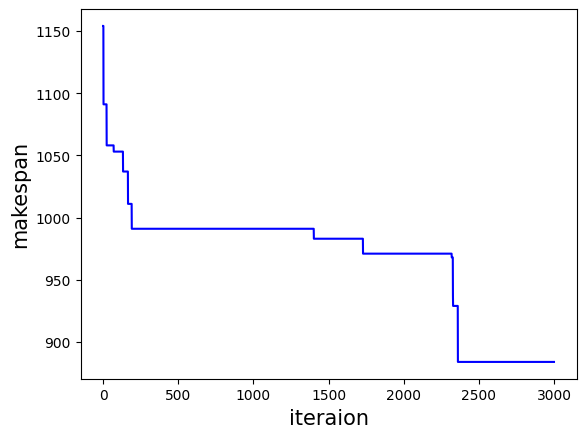

In [106]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('iteraion',fontsize=15)
plt.show()

### plot gantt chart

In [107]:
import pandas as pd
# import plotly.plotly as py
from chart_studio import plotly as py
from plotly.offline import iplot

import plotly.figure_factory as ff
import datetime

m_keys=[j+1 for j in range(num_machine)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start_time=str(datetime.timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    end_time=str(datetime.timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1
        

df=[]
for m in m_keys:
    for j in j_keys:
        df.append(dict(Task='Machine %s'%(m), Start='2023-10-15 %s'%(str(j_record[(j,m)][0])), Finish='2023-10-15 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
        # df.append(dict(Task='Machine %s'%(m), Start='2018-07-14 %s'%(str(j_record[(j,m)][0])), Finish='2018-07-14 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))

fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
iplot(fig, filename='GA_job_shop_scheduling')